In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
from sklearn.kernel_ridge import KernelRidge
from scipy.optimize import minimize
from tqdm import tqdm

MU = 1.0
T_START = 0.0
T_END = 10.0
dt = 0.5
SAVGOL_FILTER = False
y0=[0, -2]

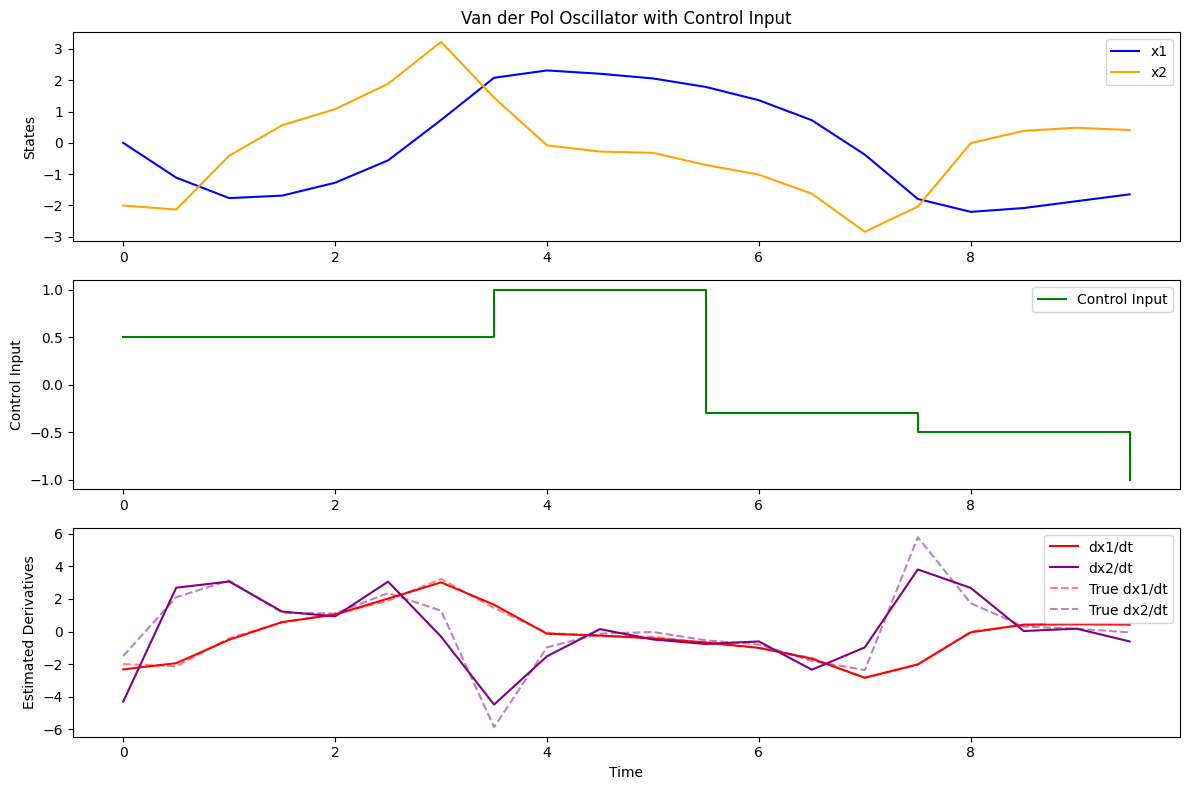

In [11]:
# Define a time-varying control input u(t) as a step function
def control_input(t):
    if t <= 3:
        return 0.5
    elif t <= 5:
        return 1.0
    elif t <= 7:
        return -0.3
    elif t <= 9:
        return -0.5
    else:
        return -1

# Van der Pol with control
def vanderpol(t, x, mu=MU):
    u = control_input(t)
    dx1 = x[1]
    dx2 = mu * (1 - x[0] ** 2) * x[1] - x[0] + u
    return [dx1, dx2]

# Simulate the system
t_eval = np.arange(T_START, T_END, dt)
sol = solve_ivp(vanderpol, [T_START, T_END], y0, t_eval=t_eval)
x1 = sol.y[0]
x2 = sol.y[1]
t = sol.t
u = np.array([control_input(ti) for ti in t])
data = pd.DataFrame({'t': t, 'x1': x1, 'x2': x2, 'u': u})   

if SAVGOL_FILTER:
    dx1_est = savgol_filter(x1, window_length=11, polyorder=3, deriv=1, delta=dt)
    dx2_est = savgol_filter(x2, window_length=11, polyorder=3, deriv=1, delta=dt)
else:        
    spline_x1 = UnivariateSpline(t, x1, s=1e-3)
    spline_x2 = UnivariateSpline(t, x2, s=1e-3)

    dx1_est = spline_x1.derivative()(t)
    dx2_est = spline_x2.derivative()(t)
    
dx1_true = []
dx2_true = []
for xi1, xi2, ti in zip(x1, x2, t):
    dx = vanderpol(ti, [xi1, xi2], mu=MU)
    dx1_true.append(dx[0])
    dx2_true.append(dx[1])

dx1_true = np.array(dx1_true)
dx2_true = np.array(dx2_true)

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t, x1, label='x1', color='blue')
plt.plot(t, x2, label='x2', color='orange')
plt.title('Van der Pol Oscillator with Control Input')
plt.ylabel('States')
plt.legend()
plt.subplot(3, 1, 2)
plt.step(t, u, label='Control Input', color='green', where='post')
plt.ylabel('Control Input')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(t, dx1_est, label='dx1/dt', color='red')
plt.plot(t, dx2_est, label='dx2/dt', color='purple')
plt.plot(t, dx1_true, label='True dx1/dt', linestyle='--', color='red', alpha=0.5)
plt.plot(t, dx2_true, label='True dx2/dt', linestyle='--', color='purple', alpha=0.5)
plt.ylabel('Estimated Derivatives')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()



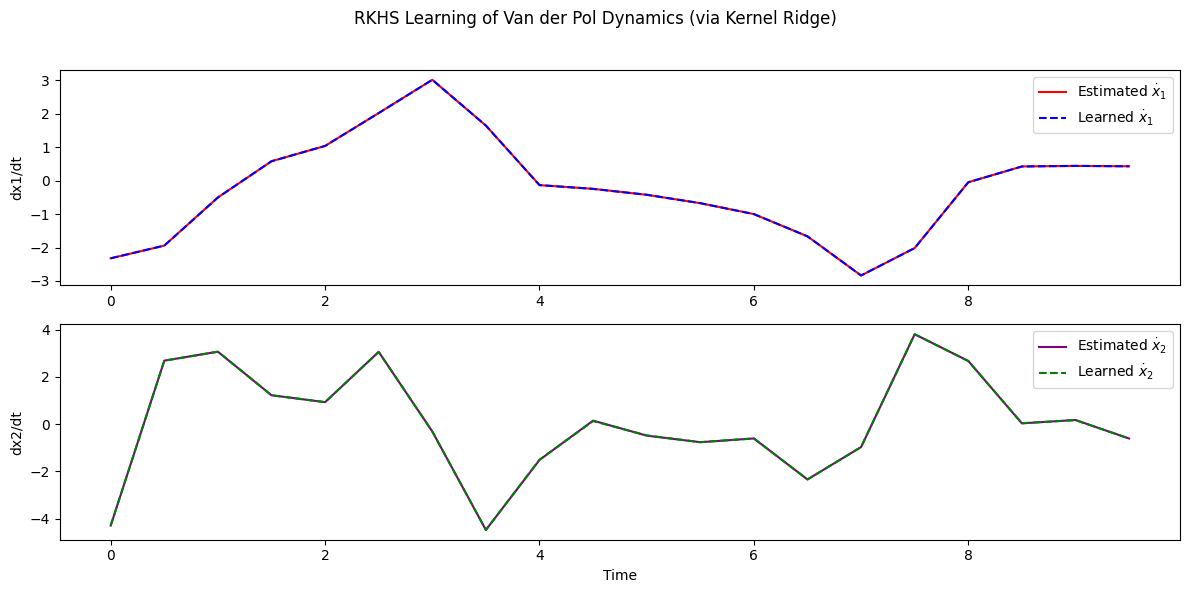

In [12]:
X_train = data[['x1', 'x2', 'u']].values
y1_train = dx1_est
y2_train = dx2_est

krr_f1 = KernelRidge(kernel='rbf', alpha=0.0001, gamma=0.5)
krr_f2 = KernelRidge(kernel='rbf', alpha=0.0001, gamma=0.5)
krr_f1.fit(X_train, y1_train)
krr_f2.fit(X_train, y2_train)

# Predict on the training data
dx1_pred = krr_f1.predict(X_train)
dx2_pred = krr_f2.predict(X_train)

# Plot estimated vs learned derivatives
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, dx1_est, label='Estimated $\dot{x}_1$', color='red')
plt.plot(t, dx1_pred, '--', label='Learned $\dot{x}_1$', color='blue')
plt.ylabel('dx1/dt')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, dx2_est, label='Estimated $\dot{x}_2$', color='purple')
plt.plot(t, dx2_pred, '--', label='Learned $\dot{x}_2$', color='green')
plt.ylabel('dx2/dt')
plt.xlabel('Time')
plt.legend()

plt.suptitle("RKHS Learning of Van der Pol Dynamics (via Kernel Ridge)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# MPC parameters
T_START, T_END = 0.0, 60.0  
TIME_RANGE = T_END - T_START
dt = 0.5                         # Time step
L = int(TIME_RANGE / dt)         # Simulation steps
N_p = 5                         # Prediction horizon
Q = 10                            # Weight for tracking
R = 1                          # Weight for control effort
Q_term = 0.0                     # Weight for terminal state
OPTIMIZATION_METHOD = 'COBYLA'    # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'
ODE_SOLVER = 'RK45'

U_MIN, U_MAX = -1.0, 1.0
BOUNDS = [(U_MIN, U_MAX) for _ in range(N_p)]  # Bounds for pedal position

In [ ]:
# Define set-point function
def set_point(t):
    trajectory = {
        (0, 15): 0,
        (15, 30): -0.5,
        (30, 45): 0.5,
        (45, float('inf')): 1
    }
    for (start, end), value in trajectory.items():
        if start <= t < end:
            return value

# Time vector
t_steps = np.arange(T_START, T_END, dt)

# Storage
x1_mpc = []
x2_mpc = []
u_mpc = []
t_mpc = []

# Initial condition
x_now = np.array([1.0, 0.0])

# Start MPC Loop
for t_now in tqdm(t_steps):
    # Define cost function to optimize
    def cost(u_sequence):
        x_pred = x_now.copy()
        total_cost = 0.0
        for k in range(N_p):
            u_k = u_sequence[min(k, len(u_sequence)-1)]
            input_features = np.array([x_pred[0], x_pred[1], u_k]).reshape(1, -1)
            dx1 = krr_f1.predict(input_features)[0]
            dx2 = krr_f2.predict(input_features)[0]
            # Forward Euler integration
            x_pred[0] += dt * dx1
            x_pred[1] += dt * dx2
            t_pred = t_now + (k+1)*dt
            r = set_point(t_pred)
            total_cost += Q * (x_pred[0] - r)**2 + R * (u_k**2)
        return total_cost

    # Initial guess for control sequence
    u_init = np.zeros(N_p)
   
    # Solve the optimization problem
    res = minimize(cost, u_init, bounds=BOUNDS, method=OPTIMIZATION_METHOD)

    # Get optimal control sequence
    u_opt = res.x

    # Apply first control action
    u_apply = u_opt[0]
    
    # Simulate one step forward using true system (optional: you can also simulate with KRR if you prefer)
    input_features = np.array([x_now[0], x_now[1], u_apply]).reshape(1, -1)
    dx1 = krr_f1.predict(input_features)[0]
    dx2 = krr_f2.predict(input_features)[0]
    x_now[0] += dt * dx1
    x_now[1] += dt * dx2
    
    # Save results
    x1_mpc.append(x_now[0])
    x2_mpc.append(x_now[1])
    u_mpc.append(u_apply)
    t_mpc.append(t_now)

# Convert to arrays
x1_mpc = np.array(x1_mpc)
x2_mpc = np.array(x2_mpc)
u_mpc = np.array(u_mpc)
t_mpc = np.array(t_mpc)

  0%|          | 0/120 [00:00<?, ?it/s]

 56%|█████▌    | 67/120 [01:55<03:14,  3.67s/it]

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(2,1,1)
plt.plot(t_mpc, x1_mpc, label='$x_1$ (Controlled)', color='blue')
plt.plot(t_mpc, [set_point(ti) for ti in t_mpc], '--', label='Setpoint', color='black')
plt.plot(t_mpc, x2_mpc, label='$x_2$ (χ)', color='orange')
plt.ylabel('$x_1$, $x_2$')
plt.legend()

plt.subplot(2,1,2)
plt.step(t_mpc, u_mpc, where='post', label='Control input $u$', color='green')
plt.ylabel('Control input $u$')
plt.xlabel('Time (s)')
plt.legend()

plt.suptitle("MPC on Van der Pol Oscillator (Learned Dynamics with KRR)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
